# ASL (American Sign Language) Recognition

## Question/Need:

Deaf people mostly use sign language to communicate. While most people do not understand sign language if they are not trained, it is necessary to develop a translator from sign language to English for better communication of deaf people. This project aims to use deep learning modeling to recognize the hand gestures corresponding to certain sign language word.

## Data Description:

The data is downloaded from Kaggle: https://www.kaggle.com/datasets/grassknoted/asl-alphabet. The dataset includes more than 4000 hand gestures for a certain alphabet from A to Z, as well as SPACE and DELETE.

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, InputLayer

import cv2
import re

### Edge detection

Essentially, the discrimination of sign language is contributed by outer contour of gesture, therefore edge detection is very important. Two types of edge detection algorithm are tested. The first one directly utlizes canny detection in opencv.

In [209]:
def edgedetect(image):
    blur = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
    res = cv2.Canny(blur,0,255)
    return img_to_array(res)

(-0.5, 199.5, 199.5, -0.5)

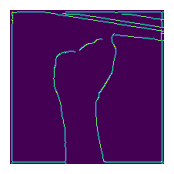

In [210]:
plt.figure(figsize=(2,2))
plt.imshow(edgedetect(cv2.imread('./asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg',0)))
plt.axis('off')

### Data preprocessing

In [211]:
train_folder = './asl-alphabet/asl_alphabet_train/asl_alphabet_train'
img_width, img_height = 64, 64
images = []
labels = []
index = 0
for folder in sorted(os.listdir(train_folder)):
    if folder != '.DS_Store':
        for image in os.listdir(train_folder + '/' + folder):
            img = edgedetect(cv2.imread(train_folder + '/' + folder + '/' + image, 0))
            images.append(img_to_array(cv2.resize(img, (img_width, img_height))))
            labels.append(index)
        index += 1
        
images = np.array(images).astype('float32')/255.0
labels = to_categorical(labels)        

Assign each index with certain sign language unit.

In [212]:
ASL_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
            10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
            19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

Split train and validation data.

In [213]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

In [215]:
batch_size = 128
y_col = 'label'
x_col = 'path'

train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size,shuffle=False)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow(x_val,y_val, batch_size=batch_size,shuffle=False)

### Create CNN model 
3 Conv block and one fully connected block. 

In [216]:
NN = Sequential()
NN.add(InputLayer(input_shape=x_train.shape[1:]))
NN.add(Conv2D(32, (3, 3), activation='relu'))
NN.add(MaxPooling2D((2, 2)))
NN.add(Conv2D(64, (3, 3), activation='relu'))
NN.add(MaxPooling2D((2, 2)))
NN.add(Conv2D(64, (3, 3), activation='relu'))
NN.add(MaxPooling2D((2, 2)))
NN.add(Flatten())
NN.add(Dense(128, activation='relu'))
NN.add(Dense(29, activation='softmax'))

Use adam optimizer and callback regularization for early stop.

In [217]:
NN.compile(
    optimizer = Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val), 
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

The accuracy is not good enough and cannot improve with increasing epoches.
The results for testing dataset are shown to be pretty accurate.

In [239]:
import re
def testdata_val(test_folder,splitname,model,edgedetect):
    images_te = []
    index = 0
    for img in sorted(os.listdir(test_folder)):
        images_te = []
    #     print('File name:',img)
        img2 = edgedetect(cv2.imread(test_folder + '/' + img, 0))
        images_te.append(img_to_array(cv2.resize(img2, (img_width, img_height))))
        images_te = np.array(images_te).astype('float32')/255.0

        test_datagen = ImageDataGenerator(rescale = 1/255.0)
        test_generator = test_datagen.flow(images_te, None, batch_size=batch_size,shuffle=False)

        pred = np.argmax(model.predict(images_te, verbose = 1),axis = 1)

        plt.figure(figsize=(2,2))    
        imgtitle = 'Sign: '+ re.split(splitname, img)[0] + '.\nPrediction: ' + ASL_dict[pred[0]]
        plt.title(imgtitle)
        plt.imshow(cv2.imread(test_folder + '/' + img))
        plt.axis('off')

1/1 [==============================] - 0s 8ms/step


/var/folders/jm/nrwptkws5fsbvfzyx3trfbcw0000gn/T/ipykernel_28478/2644769633.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(2,2))


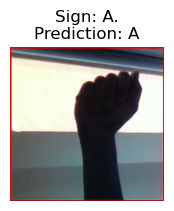

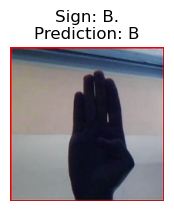

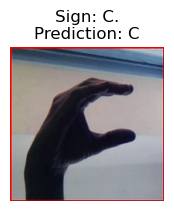

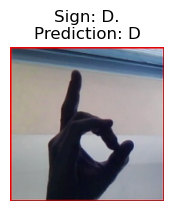

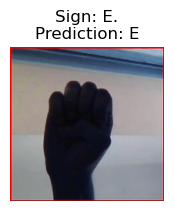

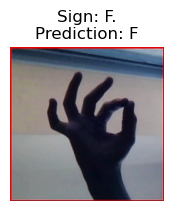

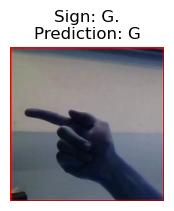

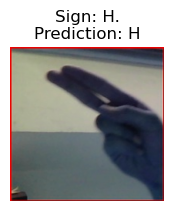

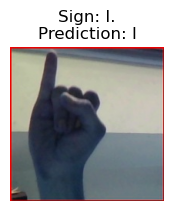

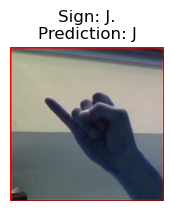

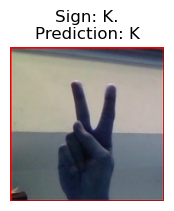

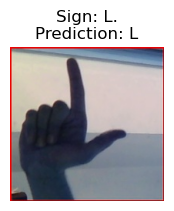

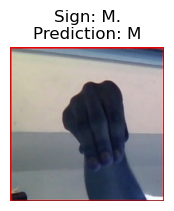

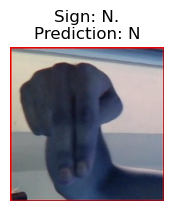

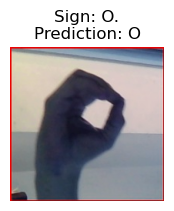

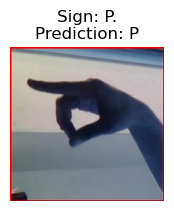

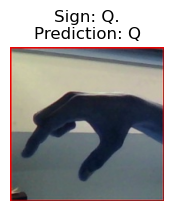

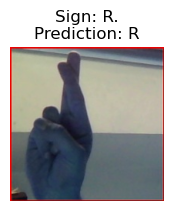

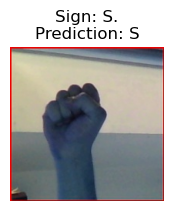

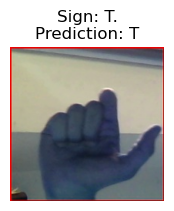

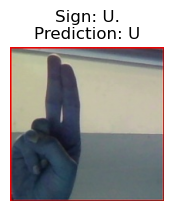

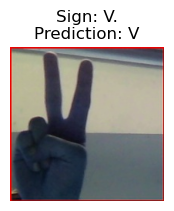

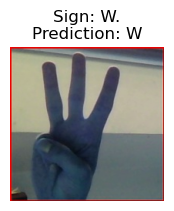

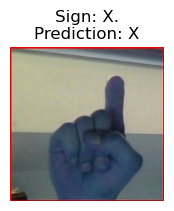

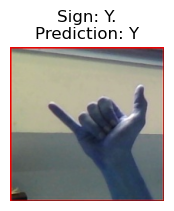

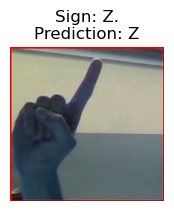

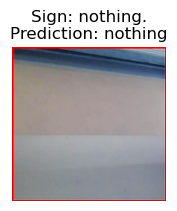

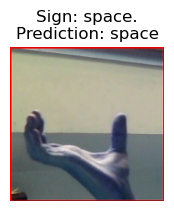

In [240]:
test_folder = './asl-alphabet/asl_alphabet_test/asl_alphabet_test'
split_fn = "_test"
testdata_val(test_folder,split_fn,NN,edgedetect)

### Another edge detection method

Another method use threhold method to suppress non maximum points and to highlight edge points.

(-0.5, 199.5, 199.5, -0.5)

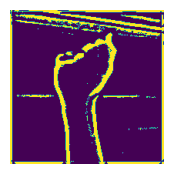

In [234]:
def edgedetect2_1(image):
    blur = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    return img_to_array(th3)

plt.figure(figsize=(2,2))
plt.imshow(edgedetect2_1(cv2.imread('./asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg',0)))
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

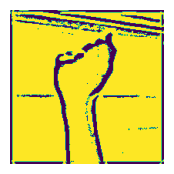

In [220]:
def edgedetect2(image):
    blur = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, 100, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return img_to_array(res)

plt.figure(figsize=(2,2))
plt.imshow(edgedetect2(cv2.imread('./asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg',0)))
plt.axis('off')

### Data processing

In [221]:
images = []
labels = []
index = 0
for folder in sorted(os.listdir(train_folder)):
    if folder != '.DS_Store':
        for image in os.listdir(train_folder + '/' + folder):
            img = edgedetect2(cv2.imread(train_folder + '/' + folder + '/' + image, 0))
            images.append(img_to_array(cv2.resize(img, (img_width, img_height))))
            labels.append(index)
        index += 1
        
images = np.array(images).astype('float32')/255.0
labels = to_categorical(labels) 
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)
train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size,shuffle=False)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow(x_val,y_val, batch_size=batch_size,shuffle=False)

(78300, 64, 64, 1)


(-0.5, 63.5, 63.5, -0.5)

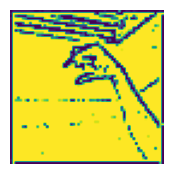

In [232]:
print(x_train.shape)
plt.figure(figsize=(2,2))
plt.imshow(x_train[0])
plt.axis('off')

In [222]:
NN2 = Sequential()
NN2.add(InputLayer(input_shape=x_train.shape[1:]))
NN2.add(Conv2D(32, (3, 3), activation='relu'))
NN2.add(MaxPooling2D((2, 2)))
NN2.add(Conv2D(64, (3, 3), activation='relu'))
NN2.add(MaxPooling2D((2, 2)))
NN2.add(Conv2D(64, (3, 3), activation='relu'))
NN2.add(MaxPooling2D((2, 2)))
NN2.add(Flatten())
NN2.add(Dense(128, activation='relu'))
NN2.add(Dense(29, activation='softmax'))

In [223]:
NN2.compile(
    optimizer = Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
NN2.summary()
NN_hist = NN2.fit(x_train, y_train, epochs=10, verbose=1, validation_data=(x_val, y_val), 
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

1/1 [==============================] - 0s 7ms/step


/var/folders/jm/nrwptkws5fsbvfzyx3trfbcw0000gn/T/ipykernel_28478/2644769633.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(2,2))


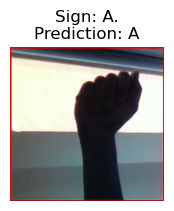

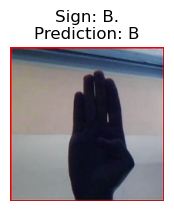

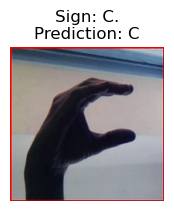

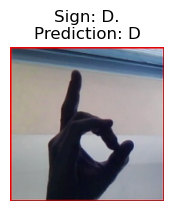

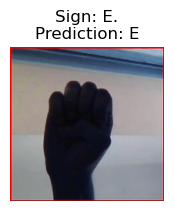

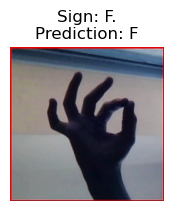

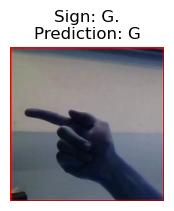

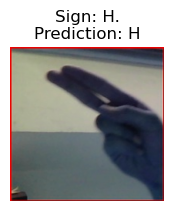

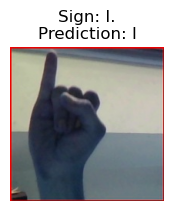

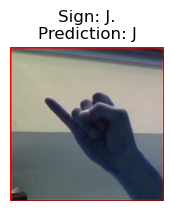

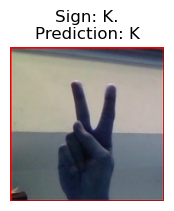

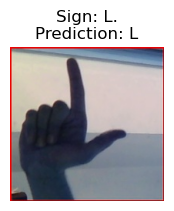

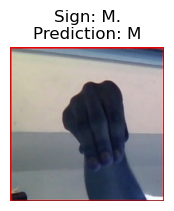

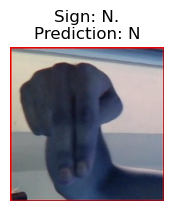

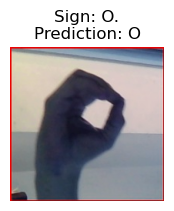

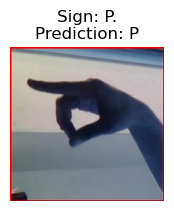

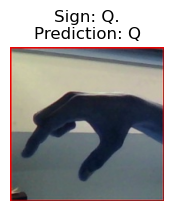

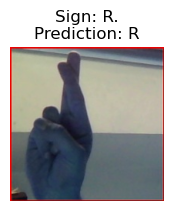

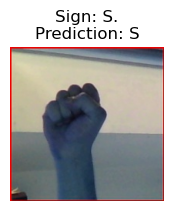

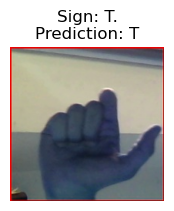

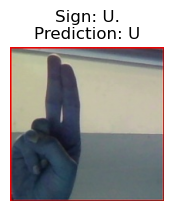

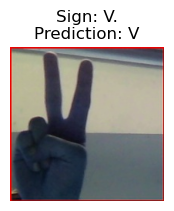

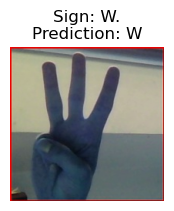

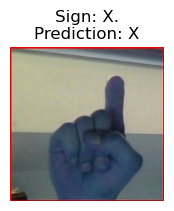

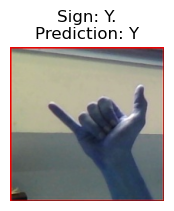

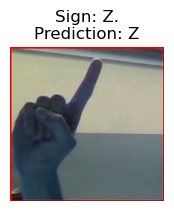

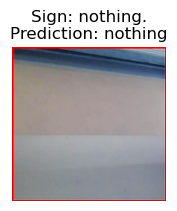

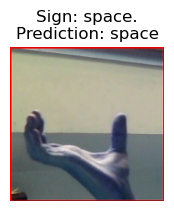

In [274]:
test_folder = './asl-alphabet/asl_alphabet_test/asl_alphabet_test'
split_fn = "_test"
testdata_val(test_folder,split_fn,NN2,edgedetect2)

### Analysis
The accuracy now are pretty good, reaching >98%. It seems that way of parsing image can impact the results a lot. High contrast and thick edge can improve the accuracy. However, both training and testing data have very similar image pattern (dark gestures and light background). The following prediction results are not so good if background pattern is not similar to the training dataset.

1/1 [==============================] - 0s 7ms/step


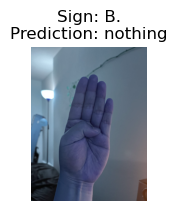

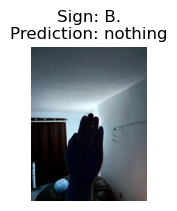

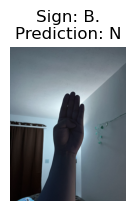

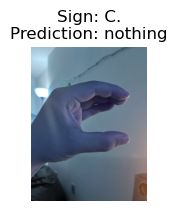

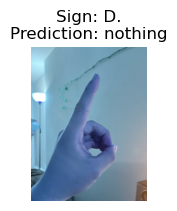

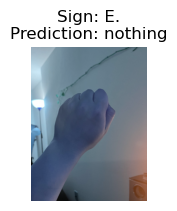

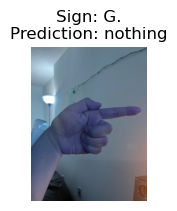

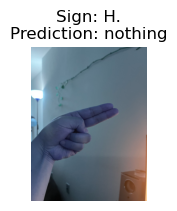

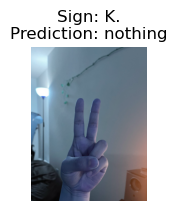

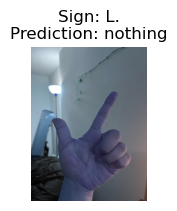

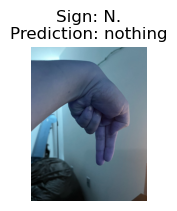

In [282]:
testdata_val('./asl-alphabet/myhand',"_mh",NN2,edgedetect2)

(-0.5, 1279.5, 1705.5, -0.5)

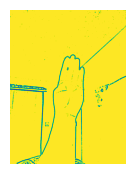

In [284]:
def edgedetect2_2(image):
    blur = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,5)
    ret, res = cv2.threshold(th3, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return img_to_array(res)

plt.figure(figsize=(2,2))
plt.imshow(edgedetect2(cv2.imread('./asl-alphabet/myhand/B_mh_dark2.jpeg',0)))
plt.axis('off')

1/1 [==============================] - 0s 7ms/step


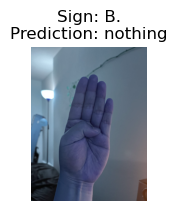

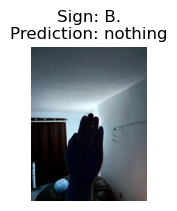

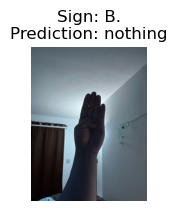

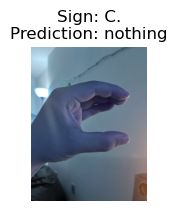

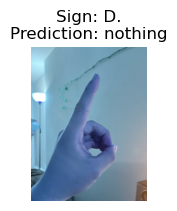

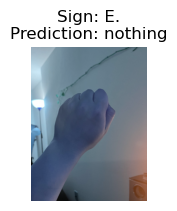

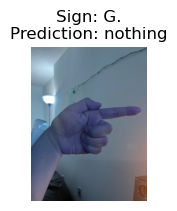

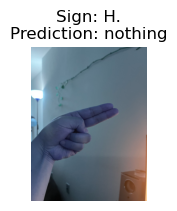

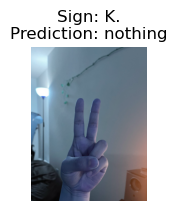

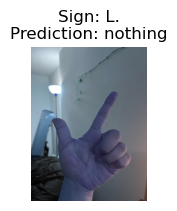

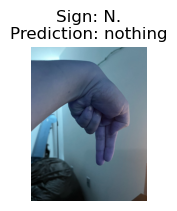

In [285]:
testdata_val('./asl-alphabet/myhand',"_mh",NN2,edgedetect2_2)

In [228]:
NN.save('./asl-alphabet/model1')
NN.save('./asl-alphabet/model2')

INFO:tensorflow:Assets written to: ./asl-alphabet/model1/assets
INFO:tensorflow:Assets written to: ./asl-alphabet/model2/assets
